# Kaggle Titanic Competition

In [52]:
%matplotlib inline

from __future__ import division
import numpy as np
import pandas as pd
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import confusion_matrix
import seaborn as sns
import csv as csv
from matplotlib import rcParams
import matplotlib.pyplot as plt
from patsy import dmatrices, dmatrix, NAAction
rcParams['figure.figsize'] = (16, 6)

train_df = pd.read_csv('train.csv')
givenTest_df = pd.read_csv('test.csv')

## Some general information
### Structure of df
    PassengerId, Survived, Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Cabin, Embarked
    survival        Survival
                    (0 = No; 1 = Yes)
    pclass          Passenger Class
                    (1 = 1st; 2 = 2nd; 3 = 3rd)
    name            Name
    sex             Sex
    age             Age
    sibsp           Number of Siblings/Spouses Aboard
    parch           Number of Parents/Children Aboard
    ticket          Ticket Number
    fare            Passenger Fare
    cabin           Cabin
    embarked        Port of Embarkation
                    (C = Cherbourg; Q = Queenstown; S = Southampton)
                    
Missing info counts:
Age is missing in 177 rows. Either drop rows where it is nan or fill in with median or do regression.
Fare has a ton of variance so idk about using it (approx 2469)
Cabin is missing in 687 rows. Either remove it entirely or fill in the rows with a new val for missing cabins. 

** Likely to have little to do with final model: **
- ticket
- fare
- name

In [2]:
print train_df.Cabin.count()


204


Looks like Cabin is pretty empty, so update df

In [3]:
df = train_df
df = df.drop(['Ticket', 'Fare', 'Name', 'Cabin'], axis=1)
ids = givenTest_df.PassengerId.as_matrix()
givenTest_df = givenTest_df.drop(['Ticket', 'Fare', 'Name', 'Cabin', 'PassengerId'], axis=1)
df.Age = df.Age.fillna(df.Age.median())
df

PassengerId  Survived  Pclass     Sex  Age  SibSp  Parch Embarked
0              1         0       3    male   22      1      0        S
1              2         1       1  female   38      1      0        C
2              3         1       3  female   26      0      0        S
3              4         1       1  female   35      1      0        S
4              5         0       3    male   35      0      0        S
5              6         0       3    male   28      0      0        Q
6              7         0       1    male   54      0      0        S
7              8         0       3    male    2      3      1        S
8              9         1       3  female   27      0      2        S
9             10         1       2  female   14      1      0        C
10            11         1       3  female    4      1      1        S
11            12         1       1  female   58      0      0        S
12            13         0       3    male   20      0      0        S
13            14         0       3    male   39      1      5        S
14            15         0       3  female   14      0      0        S
15            16         1       2  female   55      0      0        S
16            17         0       3    male    2      4      1        Q
17            18         1       2    male   28      0      0        S
18            19         0       3  female   31      1      0        S
19            20         1       3  female   28      0      0        C
20            21         0       2    male   35      0      0        S
21            22         1       2    male   34      0      0        S
22            23         1       3  female   15      0      0        Q
23            24         1       1    male   28      0      0        S
24            25         0       3  female    8      3      1        S
25            26         1       3  female   38      1      5        S
26            27         0       3    male   28      0      0        C
27            28         0       1    male   19      3      2        S
28            29         1       3  female   28      0      0        Q
29            30         0       3    male   28      0      0        S
..           ...       ...     ...     ...  ...    ...    ...      ...
861          862         0       2    male   21      1      0        S
862          863         1       1  female   48      0      0        S
863          864         0       3  female   28      8      2        S
864          865         0       2    male   24      0      0        S
865          866         1       2  female   42      0      0        S
866          867         1       2  female   27      1      0        C
867          868         0       1    male   31      0      0        S
868          869         0       3    male   28      0      0        S
869          870         1       3    male    4      1      1        S
870          871         0       3    male   26      0      0        S
871          872         1       1  female   47      1      1        S
872          873         0       1    male   33      0      0        S
873          874         0       3    male   47      0      0        S
874          875         1       2  female   28      1      0        C
875          876         1       3  female   15      0      0        C
876          877         0       3    male   20      0      0        S
877          878         0       3    male   19      0      0        S
878          879         0       3    male   28      0      0        S
879          880         1       1  female   56      0      1        C
880          881         1       2  female   25      0      1        S
881          882         0       3    male   33      0      0        S
882          883         0       3  female   22      0      0        S
883          884         0       2    male   28      0      0        S
884          885         0       3    male   25      0      0        S
885          886         0   

In [4]:
#simple function to help calculate simple probabilities
def simpleProbability(train_df, name, val):
    total = len(train_df[train_df[name] == val])
    d = (train_df[name] == val) & (train_df['Survived'] == 1)
    t_pclass = len(d[d == True])
    print('rate ' + name + ' ' + str(val) + '\t' + str(t_pclass/total))

** Affect on survival rate by class:**

In [5]:
simpleProbability(df, 'Pclass', 1)
simpleProbability(df, 'Pclass', 2)
simpleProbability(df, 'Pclass', 3)


rate Pclass 1	0.62962962963
rate Pclass 2	0.472826086957
rate Pclass 3	0.242362525458


** Affect on survival rate by sex: **

In [6]:
simpleProbability(df, 'Sex', 'male')
simpleProbability(df, 'Sex', 'female')


rate Sex male	0.188908145581
rate Sex female	0.742038216561


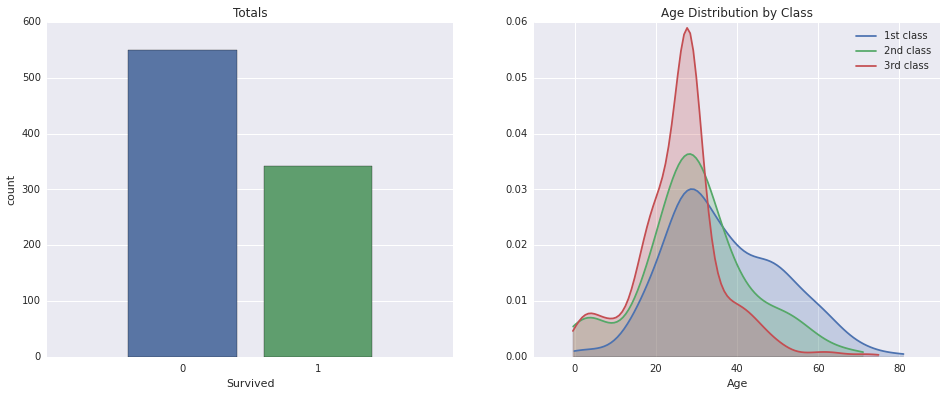

In [7]:
plt.subplot(121)
plt.title('Totals')
plotdf = pd.Series([len(df[df.Survived == 1]), len(df[df.Survived == 0])])
bar = sns.countplot(data=df, x="Survived")
bar.axes.set_xlim(-1,2)
plt.subplot(122)
plt.title('Age Distribution by Class')
plt.xlabel('Age')
sns.kdeplot(df[df.Pclass == 1].Age, shade=True, label='1st class')
sns.kdeplot(df[df.Pclass == 2].Age, shade=True, label='2nd class')
sns.kdeplot(df[df.Pclass == 3].Age, shade=True, label='3rd class')

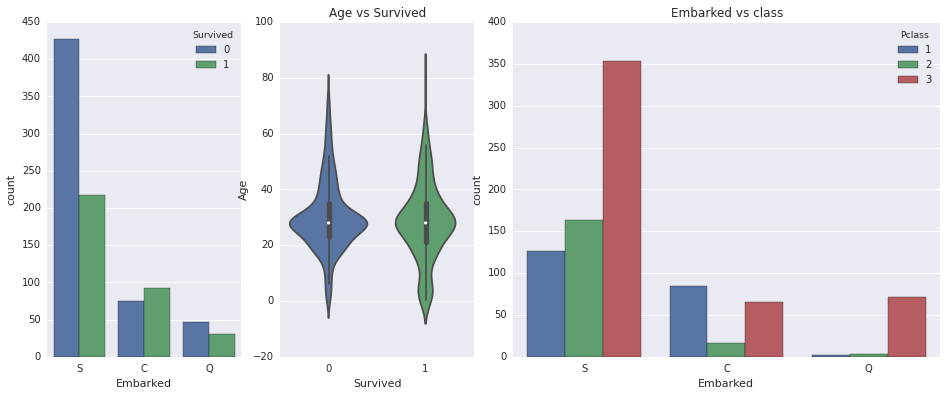

In [8]:
plt.subplot2grid((2,4), (0,0), rowspan=2)
sns.set(style="darkgrid")
sns.countplot(x="Embarked", hue="Survived", data=df)
plt.subplot2grid((2,4),(0,1), rowspan=2)
plt.title('Age vs Survived')
sns.violinplot(y=df.Age, x=df.Survived)
plt.subplot2grid((2,4),(0,2), rowspan=2, colspan=2)
plt.title('Embarked vs class')
sns.countplot(x="Embarked", hue="Pclass", data=df)

** Affect of #of siblings/spouse and #of parents/children **

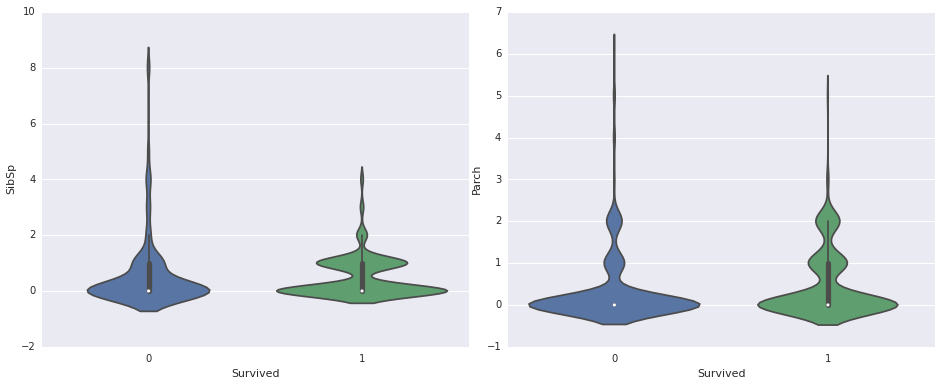

In [9]:
rcParams['figure.figsize'] = (16, 6)

plt.subplot2grid((1,4),(0,0), colspan=2)
sns.violinplot(x=df.Survived, y=df.SibSp)
plt.subplot2grid((1,4),(0,2), colspan=2)
sns.violinplot(x=df.Survived, y=df.Parch)

### Using Linear  & rbf SVC to Classify Data

In [11]:
# split df into internal train and test
train_df, test_df = df[:356], df[356:]
# Patsy formula
p_formula = 'Survived ~ C(Pclass) + C(Sex) + Age + SibSp + Parch + C(Embarked)'

# Init internal training data
y_train_i, X_train_i = dmatrices(p_formula, data=train_df, return_type='matrix')
# Init all training data
y, X = dmatrices(p_formula, data=df, return_type='matrix')

# Create test matrix
formula = 'C(Pclass) + C(Sex) + Age + SibSp + Parch + C(Embarked)'
ageMedian = df.Age.median()
givenTest_df.Age = givenTest_df.Age.fillna(ageMedian)
X_test = dmatrix(formula, data=givenTest_df)

# File output function
def writePredictionsToFile(name, predictForKaggle):
    predictions_file = open(name+".csv", "wb")
    open_file_object = csv.writer(predictions_file)
    open_file_object.writerow(["PassengerId","Survived"])
    open_file_object.writerows(zip(ids, map(lambda x: int(x), predictForKaggle)))
    predictions_file.close()

In [54]:
# Create internal test data
y_test_i, X_test_i = dmatrices(p_formula, data=test_df, return_type='matrix')
y_test_i = y_test_i.ravel()

# Init support vector classifier w. linear kernel
l_svc = SVC(kernel='linear', probability=True)
l_svc.fit(X_train_i, y_train_i.ravel())
# Init support vector classifier w. rbf kernel
rbf_svc = SVC(kernel='rbf', probability=True)
rbf_svc.fit(X_train_i, y_train_i.ravel())

# Score models
print l_svc.score(X_test_i, y_test_i)
print rbf_svc.score(X_test_i, y_test_i)

0.7734082397
0.779026217228


In [13]:
# REAL DATA
# Init support vector classifier w. linear kernel
l_svc = SVC(kernel='linear', probability=True)
l_svc.fit(X, y.ravel())
# Init support vector classifier w. rbf kernel
rbf_svc = SVC(kernel='rbf', probability=True)
rbf_svc.fit(X, y.ravel())

output = l_svc.predict(X_test)
writePredictionsToFile('LinearSVC', output)
output = rbf_svc.predict(X_test)
writePredictionsToFile('rbfSVC', output)

** Actual Score for linear kernel **: 0.75120

** Actual Score for rbf kernel **: 0.75598

### Nearest Neighbors

In [14]:
from sklearn.neighbors import KNeighborsClassifier

In [15]:
m_nn = KNeighborsClassifier(n_neighbors=9)
m_nn.fit(X_train_i, y_train_i.ravel())
m_nn.score(X_test_i, y_test_i)

0.71535580524344566

In [16]:
m_nn = KNeighborsClassifier(n_neighbors=9)
m_nn.fit(X, y.ravel())
writePredictionsToFile('9NearestNeighbors', m_nn.predict(X_test))

** Actual results of 9 nearest neighbors: **  0.71770 

### Random Forest

In [17]:
from sklearn.ensemble import RandomForestClassifier

In [50]:
clf = RandomForestClassifier(n_estimators=8, max_depth=4, criterion='entropy')
clf.fit(X_train_i, y_train_i.ravel())
clf.score(X_test_i, y_test_i)

0.80149812734082393

In [51]:
clf = RandomForestClassifier(n_estimators=4, max_depth=3)
clf.fit(X, y.ravel())
writePredictionsToFile('RandomForest4Estimators3Depth', clf.predict(X_test))

** Actual score of Random Forest with 4 est 3 depth: **  0.75598

** Actual score after using median age: ** 	0.78469

Maybe doing median age isn't good enough.
Run a regression on rest of the vars to predict age?
Also could look into specific cabin's effect on survival rate

### Gradient Boosting Classifier

In [22]:
from sklearn.ensemble import GradientBoostingClassifier

In [32]:
clf = GradientBoostingClassifier(n_estimators=100)
clf.fit(X_train_i, y_train_i.ravel())
clf.score(X_test_i, y_test_i)

0.81086142322097376

In [34]:
clf = GradientBoostingClassifier(n_estimators=150)
clf.fit(X, y.ravel())
writePredictionsToFile('GradientBoosting100Estimators', clf.predict(X_test))

** Actual score of: ** 0.77990

Looks like ensemble classifiers are doing the best in this situation

### Ada Boost Classifier

In [35]:
from sklearn.ensemble import AdaBoostClassifier

In [41]:
clf = AdaBoostClassifier(n_estimators=1500)
clf.fit(X_train_i, y_train_i.ravel())
clf.score(X_test_i, y_test_i)

0.78838951310861427

In [42]:
clf = AdaBoostClassifier(n_estimators=1500)
clf.fit(X, y.ravel())
writePredictionsToFile('AdaBoost1500', clf.predict(X_test))

** Actual score (low): **  0.74163

### Logistic Regression

In [55]:
from sklearn.linear_model import LogisticRegression

In [73]:
clf = LogisticRegression(penalty='l1', C=5)
clf.fit(X_train_i, y_train_i.ravel())
clf.score(X_test_i, y_test_i)

0.7865168539325843

In [74]:
clf = LogisticRegression(penalty='l1', C=5)
clf.fit(X, y.ravel())
writePredictionsToFile('Logit', clf.predict(X_test))

** Actual score of: ** 0.76077

### Ways to improve these models

- Do grid search to choose estimate best hyper params 